## Imports and utilities

Install qiskit and import the following packages

When using noto.epfl.ch, the command above may not work. Don't hesitate to read the documentation, otherwise open a shell and create an environement with Qiskit using the bash commands:


my_venvs_create qiskit_env
my_venvs_activate qiskit_env
pip install qiskit pylatexenc
my_kernels_create py3_qiskit "Py3 Qiskit"


Once done, please make sure to use the appropriate kernel ("py3_qiskit")

In [1]:
from qiskit import QuantumCircuit
from qiskit import Aer, transpile
from qiskit.circuit.library import GroverOperator, QFT, Diagonal
from qiskit.tools.visualization import plot_histogram, array_to_latex
from qiskit.quantum_info import Operator, Statevector

import numpy as np

Create an instance of the simulator

In [2]:
simulator = Aer.get_backend('aer_simulator')

## Problem

The 3-SAT problem is a well known instance of NP-complete problem class. It consists in having a list of classical bits $b_1, \ldots, b_n$ and finding the solution of a given predicate in the form of conjunctions of three-disjunctions. For instance, here is a 3-SAT predicate:
\begin{equation}
    f(x_0, x_1, x_2) = (x_0 \lor x_1 \lor \lnot x_2) \land (\lnot x_0 \lor \lnot x_1 \lor x_2) \land ( x_0 \lor \lnot x_1 \lor x_2)
\end{equation}

One looks for solutions of $f(x_0,x_1,x_2)=1$.
Using a Grover algorithm can help find solutions of a predicate with a quadratic speed-up over a naive exhaustive search. Another aspect is the counting problem of the number of solutions satisfying the predicate. In the following, we will implement such an algorithm using different pieces seen in previous homeworks.

This miniproject is divided in 3 parts:
1. The first part consist in designing a block $U_f$ 
2. In the second part, you will create a Grover rotation operator with the block created in the first part
3. In the last part, you will use the quantum phase estimation algorithm to answer the counting problem



lowing, we will implement such an algorithm using different pieces seen in previous homeworks.

This miniproject is divided in 3 parts:
1. The first part consist in designing a block $U_f$ 
2. In the second part, you will create a Grover rotation operator with the block created in the first part
3. In the last part, you will use the quantum phase estimation algorithm to answer the counting problem



### Part 1: desiging $U_f$

Let's consider first a simpler case to show you an example: $ g(x_0,x_1,x_2) = (\lnot x_0 \lor \lnot x_1) \land (x_2 \lor \lnot x_0) $ and check how to design the block $U_g$.
**The method does not use any knowledge of the solution of the function $g$. When you will design your own circuit, you will not be allowed to use knowledge of the solution for $f$.**

In this method, the following number of qubits are required for $U_g$: 
* $3$ qubits to encode each value of $x_i$ for $i \in \left\{0,1,2\right\}$. 
* $2$ additional "hidden" ancilla qubits to encode the first clause: $(\lnot x_0 \lor \lnot x_1)$ and the second clause: $(x_2 \lor \lnot x_0)$.
* $1$ final ancilla qubit $\lvert c \rangle$ where we apply the transformation $\lvert g(x_0,g_1,x_2) \oplus c \rangle$, as usual.

Therefore, in total we require $3+2+1 = 6$ qubits. The total effect of $U_g$ can be represented by the following expression:

$$U_g \lvert x_0, x_1, x_2 \rangle \otimes \lvert 0,0 \rangle \otimes \lvert c \rangle = \lvert x_0, x_1, x_2 \rangle \otimes \lvert 0,0 \rangle \otimes \lvert c \oplus g(x_0,x_1,x_2) \rangle$$

Let's create it:

In [3]:
U_g = QuantumCircuit(6, name="U_g")

For now, the circuit is empty. We will start the first clause "$(\lnot x_0 \lor \lnot x_1)$". We will only handle logical "and" gates (using CCNOT or multi-control-not) and avoid logical "or" gates. To this end, we use De Morgan's laws on the clause: $(\lnot x_0 \lor \lnot x_1) = \lnot (x_0 \land x_1)$. 

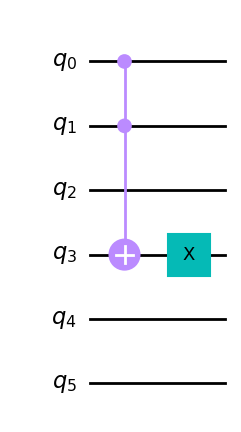

In [4]:
U_g.mcx([0,1], 3) # CCX on the qubit 0 and 1 with target 3
U_g.x(3) # at this point, we use X for the NOT operator



(U_g).draw(output='mpl')

With the same procedure on the second clause we have: $(x_2 \lor \lnot x_0) = \lnot (\lnot x_2 \land x_0)$. Compared with the first clause, a NOT needs to be applied to $x_2$. Remember that $U_g$ leaves $\lvert x_0,x_1,x_2 \rangle$ unchanged, so we need to revert the NOT operator on $x_2$ at the end of the procedure.

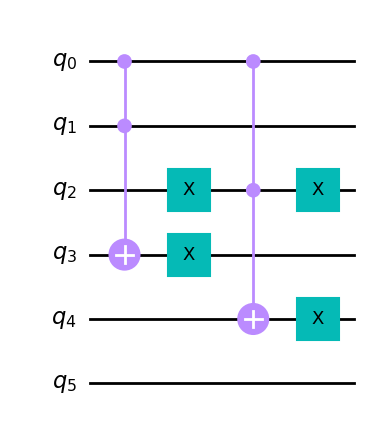

In [5]:
U_g.x(2) # the NOT on x_2

U_g.mcx([2,0], 4) # we use CCX on the qubit 0 and 1 with target 4
U_g.x(4) # at this point, we use X to have the initial NOT operator

U_g.x(2) # IMPORTANT: we revert the NOT on x_2


U_g.draw(output='mpl')

Finally, We just use the quantum logical "and" on the "hidden" ancilla qubits 3 and 4.

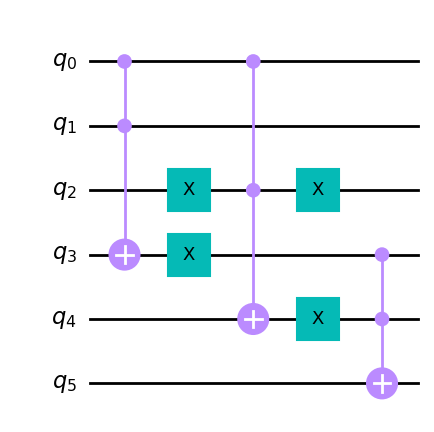

In [6]:
U_g.mcx([3,4], 5)

U_g.draw(output='mpl')

Now remember that the effect of $U_g$ is the following: 

$$U_g \lvert x_0, x_1, x_2 \rangle \otimes \lvert 0,0 \rangle \otimes \lvert c \rangle = \lvert x_0, x_1, x_2 \rangle \otimes \lvert 0,0 \rangle \otimes \lvert c \oplus g(x_0,x_1,x_2) \rangle$$

At this point, the last ancilla qubit $c$ is properly xored, the qubits encoding for $x_i$ are also back to their initial states, but if we want to reuse the hidden qubits we also need to bring them back to $\lvert 0,0 \rangle$ (we will need to use $U_g$ multiple times with Grover). So we need to "rewind" our calculations.

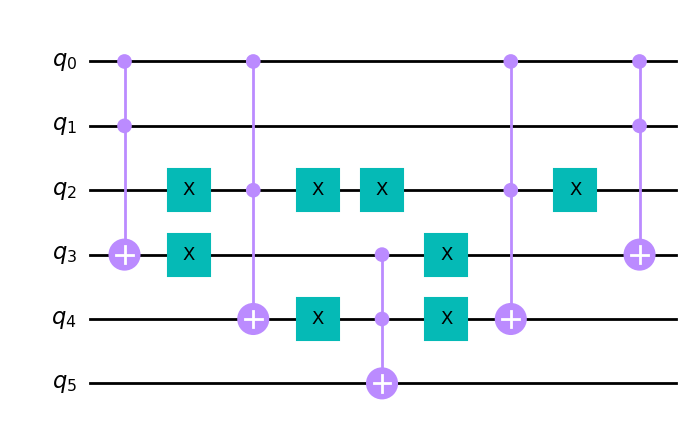

In [7]:
# Revert the second clause
U_g.x(2) # IMPORTANT: we reset the NOT on x_2
U_g.x(4) # at this point, we use X to have the initial NOT operator
U_g.mcx([2,0], 4) # we use CCX on the qubit 0 and 1 with target 4
U_g.x(2) # the NOT on x_2

# Revert the first clause
U_g.x(3) # at this point, we use X to have the initial NOT operator
U_g.mcx([0,1], 3) # we use CCX on the qubit 0 and 1 with target 3

U_g.draw(output='mpl')

Now we can test our circuit and check that the last ancilla qubit yields $1$ with the proper entries. We will create a new circuit and append $U_g$:

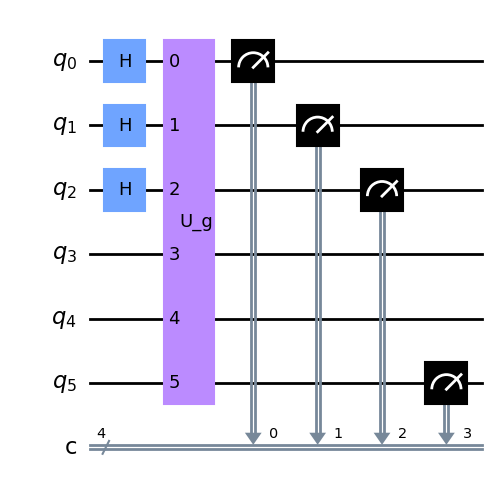

In [8]:
test_circuit = QuantumCircuit(6,4) # 6 qubits, 4 classical registers

# Hadamard on the first 3 qubits x_0,x_1,x_2
test_circuit.h([0,1,2]) 

# U_g is applied on qubits 0 to 5
test_circuit.append(U_g, [0,1,2,3,4,5]) 

# Measurement of the qubits x_0,x_1,x_2
test_circuit.measure(0,0)
test_circuit.measure(1,1)
test_circuit.measure(2,2)

# Measurement of the ancilla qubit c
test_circuit.measure(5,3)

# Draw the circuit
test_circuit.draw(output='mpl')

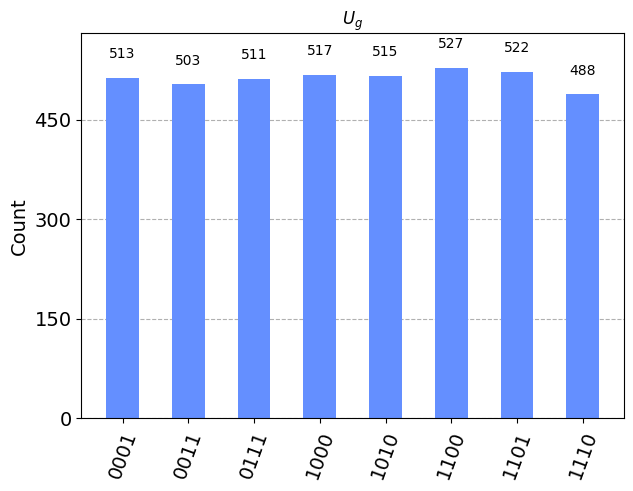

In [9]:
# Transpile the circuit
transpiled_circuit = transpile(test_circuit, simulator)

# Run the circuit
result = simulator.run(transpiled_circuit, shots=4096).result()

# Retrieve and display the results
counts = result.get_counts(transpiled_circuit)
plot_histogram(counts, title='$U_g$')

Now $g(x_0,x_1,x_2) = 1$ either when $(x_0=0)$ or when $(x_0=1, x_1 = 0, x_2 = 1)$. **Pay attention to the order of the bits in the previous graph**, but convince yourself that indeed, the correct solutions are displayed with the ancilla qubit set to $1$.


Now it is your turn:

#### Question 1

<span style="color:blue"> You will implement the $U_f$ block with the $f$ given at the beginning of the notebook. How many qubits do you need? Give your explanation by writing the effect of $U_f$</span>.

In [10]:
N_qubits = 7 # Your Answer

_Your Explanations..._

To implement this, I will need:

- 3 qubits for the variables $x_0$, $x_1$, $x_2$.
- 3 additional ancilla qubits to handle each clause of the 3-SAT problem.
- 1 final ancilla qubit that will be flipped if and only if all clauses are true.

Total, I need 3 (for variables) + 3 (for clause ancillae) + 1 (for final ancilla) = 7 qubits.

The effect of $U_f$ will be:

$$U_f |x_0, x_1, x_2 \rangle \otimes |0,0,0 \rangle \otimes |c \rangle = |x_0, x_1, x_2 \rangle \otimes |0,0,0 \rangle \otimes |c \oplus f(x_0,x_1,x_2) \rangle$$

- Where $\oplus$ is the XOR operation. 
-  $c$ will be flipped if and only if $f(x_0,x_1,x_2)=1$. 
- In other words, if and only if the input satisfies the 3-SAT problem. 

This $U_f$ block will be used as the oracle in the Grover's algorithm.

\begin{equation}
    f(x_0, x_1, x_2) = (x_0 \lor x_1 \lor \lnot x_2) \land (\lnot x_0 \lor \lnot x_1 \lor x_2) \land ( x_0 \lor \lnot x_1 \lor x_2)
\end{equation}




#### Question 2

<span style="color:blue">Create the circuit $U_f$ in the same spirit as $U_g$ and draw it</span>.

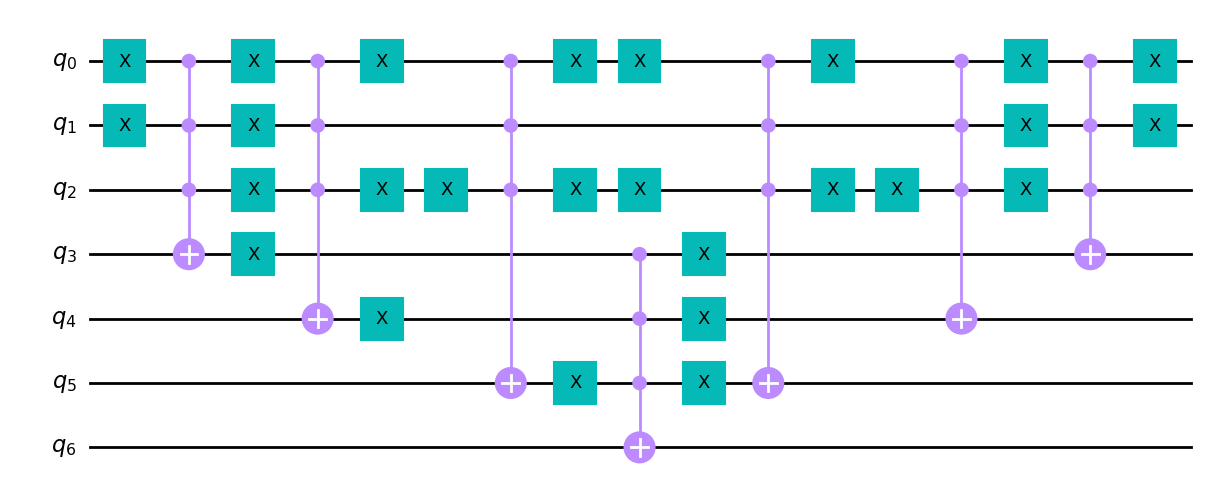

In [11]:
U_f = QuantumCircuit(N_qubits, name="U_f")

######### (BEGIN) Your answer ##################


# Handle clause ( x_0 v x_1 v ‘x_2 )
U_f.x([0,1]) # the NOT on x_2 
U_f.mcx([0,1,2], 3) # we use CCX on the qubit 0, 1 and 2 with target 3 
U_f.x(3) # the NOT on x_2
U_f.x([0,1]) # the NOT on x_2 

# Handle clause ( 'x_0 v 'x_1 v x_2 )
U_f.x(2) # the NOT on x_0
U_f.mcx([0,1,2], 4) # we use CCX on the qubit 0, 1 and 2 with target 4
U_f.x(4) # the NOT on x_2
U_f.x(2) # the NOT on x_0

# Handle clause ( x_0 v 'x_1 v x_2 )
U_f.x([0,2]) # the NOT on x_1
U_f.mcx([0,1,2], 5) # we use CCX on the qubit 0, 1 and 2 with target 5
U_f.x(5) # the NOT on x_2
U_f.x([0,2]) # the NOT on x_1

# Connect all the clauses
U_f.mcx([3,4,5], 6)

U_f.x([0,2])
U_f.x(5)
U_f.mcx([0,1,2], 5)
U_f.x([0,2])



U_f.x(2)
U_f.x(4)
U_f.mcx([0,1,2], 4)
U_f.x(2)

U_f.x([0,1])
U_f.x(3)
U_f.mcx([0,1,2], 3)
U_f.x([0,1])



######### ( END ) Your answer ##################

U_f.draw(output='mpl')

#### Question 3

<span style="color:blue">Test your U_f block, then plot the solutions, and write down all the tuples solution of $f(x)=1$. How many solutions do you have?</span>

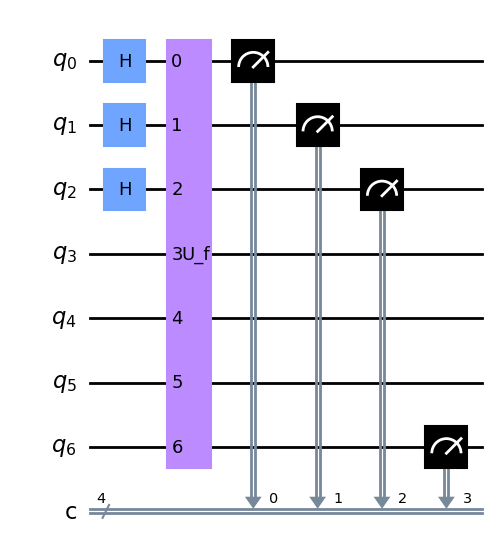

In [12]:
test_circuit = QuantumCircuit(N_qubits, 4)

######### (BEGIN) Your answer ##################
#Test your U_f block, then plot the solutions, and write down all the tuples solution of $f(x)=1$. How many solutions do you have?</span>
# Create a quantum circuit with 7 qubits and 4 classical bits

# Apply Hadamard gates to the first 3 qubits x_0,x_1,x_2
test_circuit.h([0,1,2]) 

# Append the U_f gate to our test circuit. 
# U_f operates on all 7 qubits
test_circuit.append(U_f, [0,1,2,3,4,5,6]) 

# Measure the qubits x_0,x_1,x_2
test_circuit.measure(0,0)
test_circuit.measure(1,1)
test_circuit.measure(2,2)

# Measure the ancilla qubit used for the conjunction of clauses
test_circuit.measure(6,3)


######### ( END ) Your answer ##################

test_circuit.draw(output='mpl')


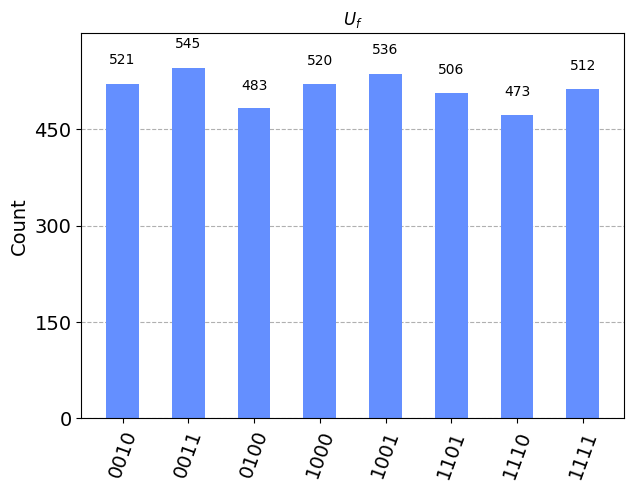

In [13]:
transpiled_circuit = transpile(test_circuit, simulator)

result = simulator.run(transpiled_circuit, shots=4096).result()
counts = result.get_counts(transpiled_circuit)
plot_histogram(counts, title='$U_f$')

_Write down all the tuples $(x_0,x_1,x_2)$..._

In [14]:
N_solutions = 5 # Write down your number of solutions

### Part 2: Grover Rotation operator

Based on your previous answer, let's calculate your theoretical $\theta_0$ as in the course

In [15]:
theta0 = np.arcsin(np.sqrt(N_solutions/8))

print(f"theta_0 = {theta0:0.2f}")

theta_0 = 0.91


Now let's create the Grover rotation operator based on your $U_f$ block

In [16]:
grover_op = GroverOperator(U_f, reflection_qubits=[0, 1, 2], name="G") 

#### Question 4

<span style="color:blue">
Remember that applying Grover operator $k$ times outputs the state:
$$\sin((2k+1)\theta_0) \lvert S \rangle + \cos((2k+1)\theta_0) \lvert P \rangle$$
    
   Based on your value of $\theta_0$ what would be a good value $k$ to run the algorithm? Explain it.
</span>


In [17]:
k = 8# Your solution

_Your explanations_

Initially, the system is found in the state |S⟩. With each iteration of the algorithm, the Grover operator is applied, which has the effect of rotating the state closer to |w⟩. The degree of rotation enacted by each iteration is $2\theta_0$. So, after $k$ iterations, the state's orientation has been adjusted by an angle of $2k\theta_0$.

The objective is to cease iterations when the state is sufficiently close to |w⟩. At this point, a measurement of the system is highly likely to yield the correct answer. This condition is achieved when the total angle of rotation, denoted as $(2k+1)\theta_0$, is approximately $\frac{\pi}{2}$. This arises from the fact that the probability amplitude of the state |w⟩ is given by $\sin((2k+1)\theta_0)$, which reaches its peak value of 1 when its argument is $\frac{\pi}{2}$.

By rearranging the equation $(2k+1)\theta_0 = \frac{\pi}{2}$, we can solve for $k$ to find $k = \frac{\frac{\pi}{2}}{2 \cdot \theta_0} - \frac{1}{2}$. Given your value of $\theta_0 = 1.57$, the resulting $k$ value is approximately zero.

The number of iterations, $k$, however, must be an integer. Thus, we round to the nearest integer, which in this case is zero. But since the Grover operator should be applied at least once for the algorithm to have an effect, one would typically increment $k$ is: 

$k = \left(\frac{\frac{\pi}{2} - 1.57}{2 \times 1.57}\right) \approx 0.08$

$ k = 8 $ 

### K need to be int and we want at least K >= 1 ,additionally the fact of achiving Eps environment of   $\frac{\pi}{2}$

However, this is a somewhat idealized explanation. In practical situations, factors like the discretization of the number of iterations or quantum noise can introduce variances. As a result, the optimal number of iterations might need to be determined experimentally.

<span style="color:blue">

Based on your solution above, complete the Grover algorithm below, display the circuit and run the code to generate the histogram of the solutions</span>


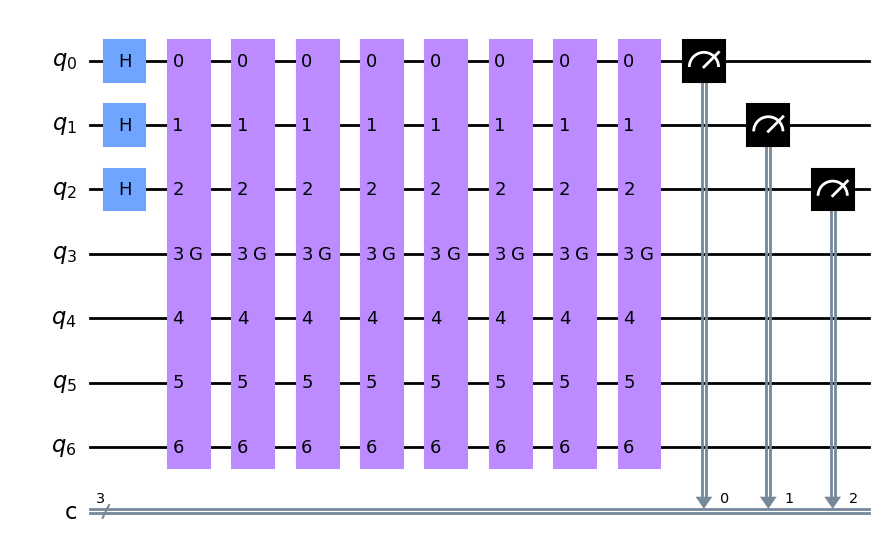

In [18]:
grover_search_circuit = QuantumCircuit(N_qubits, 3)


######### (BEGIN) Your answer ##################

# Initialize states
grover_search_circuit.h([0, 1, 2])

# Apply Grover's operator k times
for _ in range(k):
    grover_search_circuit.append(grover_op, range(N_qubits))

# Measure the variable qubits x_0, x_1, x_2
grover_search_circuit.measure(0, 0)
grover_search_circuit.measure(1, 1)
grover_search_circuit.measure(2, 2)

# Draw the circuit
grover_search_circuit.draw(output='mpl')

# Transpile and run the circuit
transpiled_circuit = transpile(grover_search_circuit, simulator)
result = simulator.run(transpiled_circuit, shots=4096).result()

# Display the histogram of the results
plot_histogram(result.get_counts(transpiled_circuit), title='counts')

######### ( END ) Your answer ##################

# Draw the circuit
grover_search_circuit.draw(output='mpl')

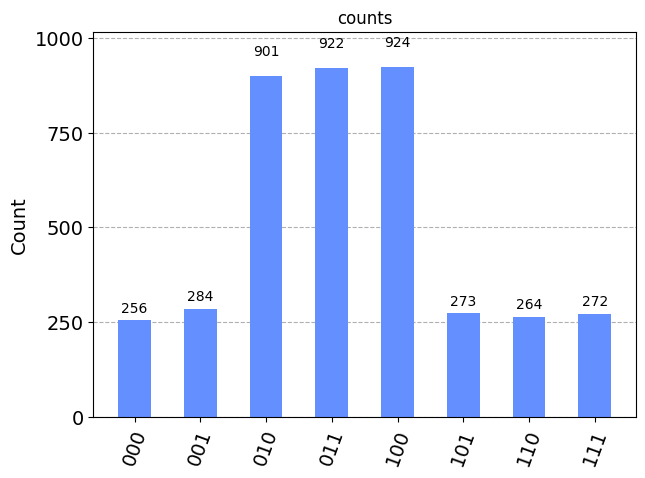

In [19]:
tcircuit = transpile(grover_search_circuit, simulator)
result = simulator.run(tcircuit, shots=4096).result()
plot_histogram(result.get_counts(tcircuit), title='counts')

you should see that the Grover Algorithm amplifies the expected solutions.

### Part 3: The Phase estimation algorithm


You have seen the quantum phase estimation algorithm in Homework 8. The idea is the following: given a block matrix $U$ with an eigenvalue $e^{2i \pi \alpha}$ with $\alpha \in (0,1)$ associated to an eigenvector $\lvert \phi \rangle$ (ie $U \lvert \phi \rangle = e^{2i \pi \alpha} \lvert \phi \rangle$), it is possible to estimate $\alpha$ with $m$ bits in base $2$ using $m$ qubits. (ie, $\alpha = \sum_{j=0}^{m-1} \frac{\alpha_j}{2^j}$ with $\alpha_j \in \left\{0, 1 \right\}$ )

Let's implement a simplistic version with a fictitious block $U$ with only one eigenvalue $e^{2i \pi \alpha}$:

In [20]:
# Let's define the eigenvalue
alpha = 0.42 # any value between 0 and 1
eig0 = np.exp(2*1J*np.pi*alpha)

# We create a diagonal operator acting on 1 qubit
U = Diagonal([eig0, eig0])

Now that our fictious block $U$ is working, let's create the control-U^n block with the following helper:

In [21]:
def control_U_power_n(U, n):
    circuit = QuantumCircuit(1, name=f"U^{n}")
    
    for _ in range(n):
        circuit.append(U, [0])
    
    circuit = transpile(circuit, simulator)
    return circuit.control(1)

Finally, we create the quantum phase algorithm as follow where the initial vector given in $U$ is here given by $\lvert \phi\rangle = H \lvert 0 \rangle$. We will use a precision of 5 bits for our measurement.

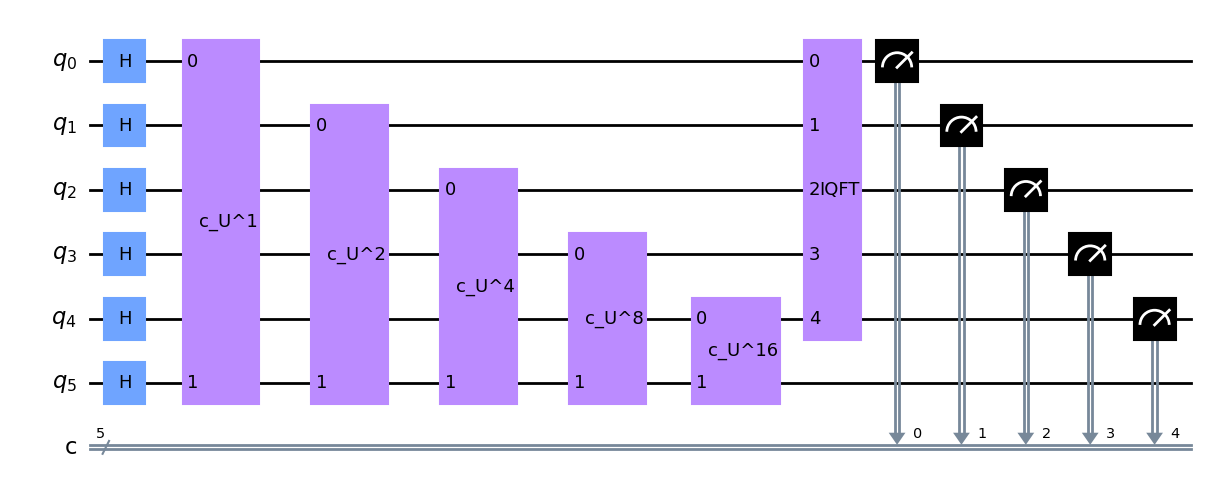

In [22]:
N_measures = 5

main_circuit = QuantumCircuit(1+N_measures,N_measures)

# Hadamard on qubits measuring the eigenvalue and the qubit of U
main_circuit.h(list(range(N_measures+1)))

# We apply c-U^(2^i)  
for i in range(N_measures):
    main_circuit.append(control_U_power_n(U, 1 << i), [i,5])

# Inverse QFT gate
QFTgate = QFT(num_qubits=N_measures, inverse=True, insert_barriers=False)
main_circuit.append(QFTgate, list(range(N_measures)))

# Measurement
for i in range(N_measures):
    main_circuit.measure(i,i)
    
# Draw the circuit
main_circuit.draw(output='mpl')

Let's run the circuit and check the output:

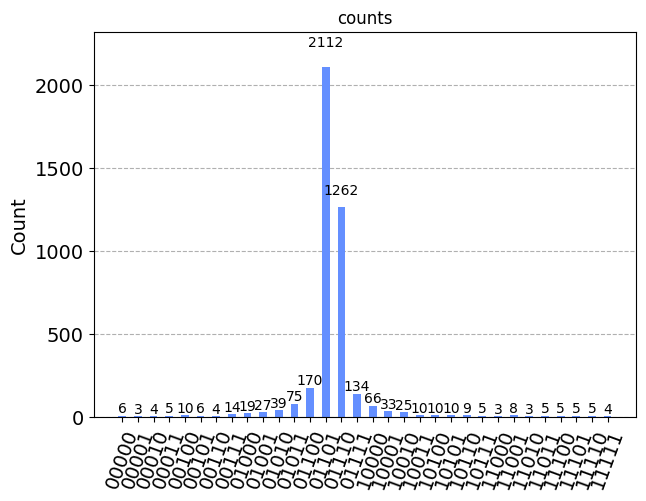

In [23]:
tcircuit = transpile(main_circuit, simulator)
result = simulator.run(tcircuit, shots=4096).result()
counts = result.get_counts(tcircuit)
plot_histogram(counts, title='counts')

To make things nicer to read, let's create a helper function to convert the binary measure to a float number

In [24]:
def bin_to_float(s):
    a = int(s,2)
    alpha = a/(2**N_measures)
    return np.round(alpha, 2)

Now let's print again the historgram

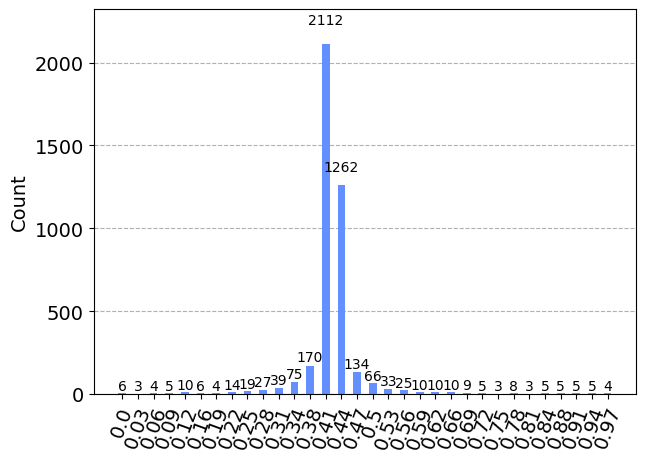

In [25]:
plot_histogram({bin_to_float(k):v for k,v in counts.items()})

As we can see, $\alpha$ is revealed through the histogram.

What if $U$ has $2$ eigenvalues? Let's check it by creating a second fictitious $U$ gate.

In [26]:
# Create a second eigenvalue
beta = 0.27
eig1 = np.exp(2*1J*np.pi*beta)

# a diagonal block acting on 1 qubit with 2 eigenvalues 
U_new = Diagonal([eig0, eig1])

There are now two eigenvalues:
* $e^{2i\pi \alpha}$ with eigenvector $\lvert 0 \rangle$ 
* $e^{2i\pi \beta}$ with eigenvector $\lvert 1 \rangle$. 

By linearity, when initialized with $\lvert \phi \rangle = H \lvert 0 \rangle = \frac{1}{\sqrt2} \left(\lvert 0 \rangle +\lvert 1 \rangle \right)$, one can expect that sometimes we would make a measurement for the first eigenvalue, and sometimes for the second one. Let's run again our algorithm and check that this is the case.

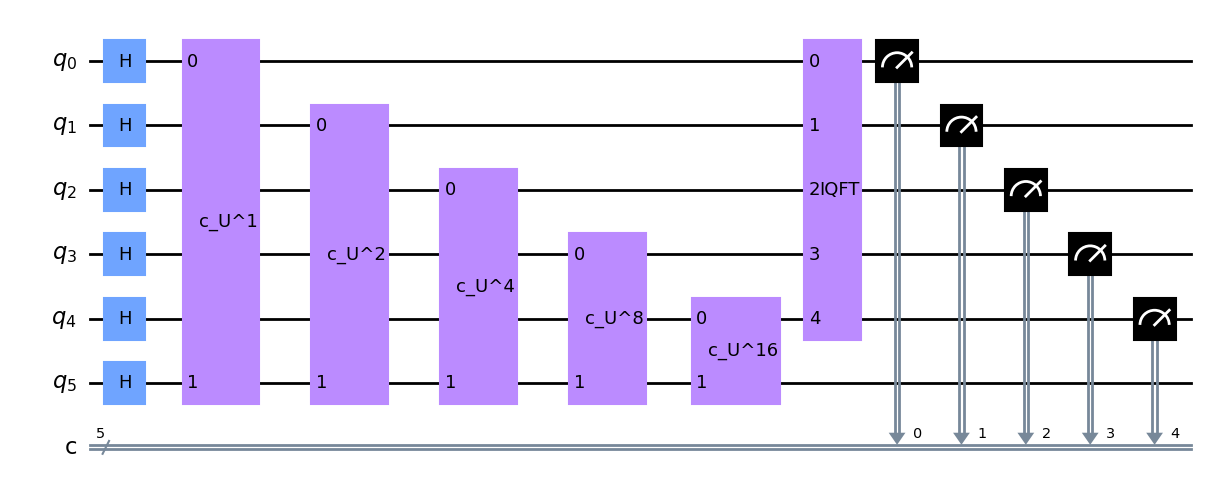

In [27]:
N_measures = 5

main_circuit = QuantumCircuit(1+N_measures,N_measures)

# Hadamard on qubits measuring the eigenvalue and the qubit of U_new
main_circuit.h(list(range(N_measures+1)))

# We apply c-U^(2^i)  
for i in range(N_measures):
    main_circuit.append(control_U_power_n(U_new, 1 << i), [i,5]) # U_new instead of U

# Inverse QFT gate
QFTgate = QFT(num_qubits=N_measures, inverse=True, insert_barriers=False)
main_circuit.append(QFTgate, list(range(N_measures)))

# Measurement
for i in range(N_measures):
    main_circuit.measure(i,i)
    
# Draw the circuit
main_circuit.draw(output='mpl')

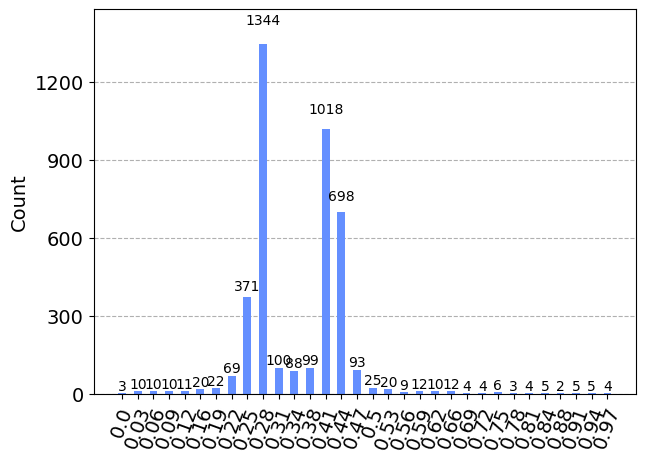

In [28]:
tcircuit = transpile(main_circuit, simulator)
result = simulator.run(tcircuit, shots=4096).result()
counts = result.get_counts(tcircuit)
plot_histogram({bin_to_float(k):v for k,v in counts.items()})

This is indeed the case and we can clearly see our eigenvalues.



#### Question 5

<span style="color:blue">
Now let's see how this fits in with our Grover operator. Remember that the Grover operator $G$ acts as a rotation of angle $2\theta_0$ in the 2d-subspace spanned by the vectors $\lvert S \rangle$ and $\lvert P \rangle$.
    
Show that $G$ has $2$ eigenvalues in that subspace, and express them
</span>

The Grover's operator acts as followed on a vector:
$$
G\lvert \Psi \rangle = G(cos\theta\lvert S \rangle + sin\theta\lvert P \rangle) = cos(3\theta)\lvert S \rangle + sin(3\theta)\lvert P \rangle
$$

Thus, in the basis $\{\lvert S \rangle, \lvert P \rangle\}$, $G$ is a rotation matrix of angle $2\theta$ so
$$
G = \begin{pmatrix}
cos2\theta & -sin2\theta \\
sin2\theta & cos2\theta
\end{pmatrix}
$$

The eigenvalues of such a matrix are $e^{\pm i2\theta}$.

#### Question 6

<span style="color:blue">
    Implement the quantum Grover phase estimation algorithm based on a similar construction as before.
</span>

In [29]:
N_measures = 5

main_circuit = QuantumCircuit(N_qubits+N_measures,N_measures)

######### (BEGIN) Your answer ##################
def control_G_power_n(G, n):
    circuit = QuantumCircuit(N_qubits, name=f"G^{n}")
    
    for _ in range(n):
        circuit.append(G, range(0, N_qubits))
    
    circuit = transpile(circuit, simulator)
    return circuit.control(1, "CTRL BIT")

# Hadamard on qubits measuring the eigenvalue and the qubit of U_f
main_circuit.h(list(range(N_qubits+N_measures - 4)))

# We apply c-G(2^i)  
for i in range(N_measures):
    G_power_n = control_G_power_n(grover_op, 1 << i)
    main_circuit.append(G_power_n, [i] +  list(range(N_measures, N_measures + N_qubits)))
    
# Inverse QFT gate
QFTgate = QFT(num_qubits=N_measures, inverse=True, insert_barriers=False)
main_circuit.append(QFTgate, list(range(N_measures)))

# Measurement
for i in range(N_measures):
    main_circuit.measure(i,i)
    
# To debug control_G_power_n:
# control_G_power_n(grover_op, 2).draw(output='mpl')

######### ( END ) Your answer ##################

Let's draw your circuit

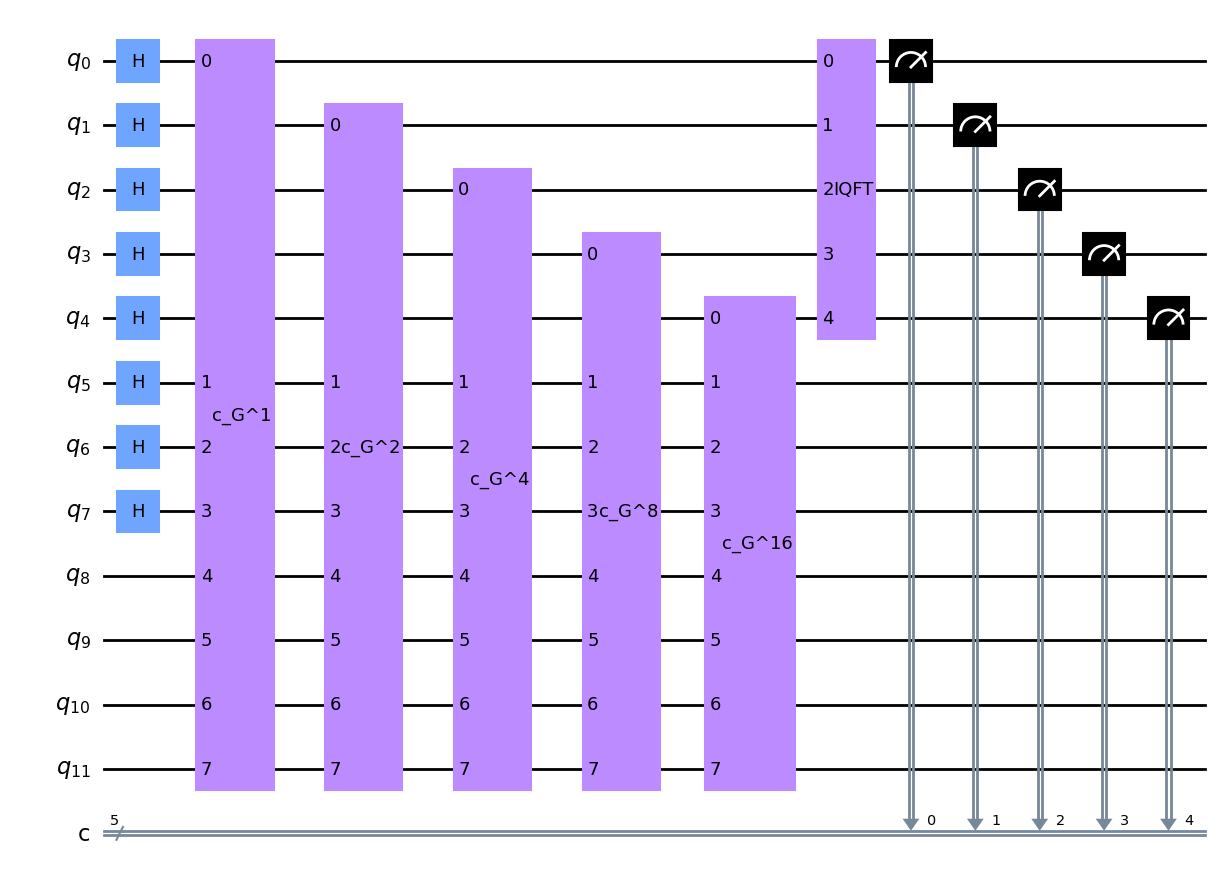

In [30]:
######### (BEGIN) Your answer ##################

main_circuit.draw(output='mpl')

######### ( END ) Your answer ##################

and run and plot the histogram

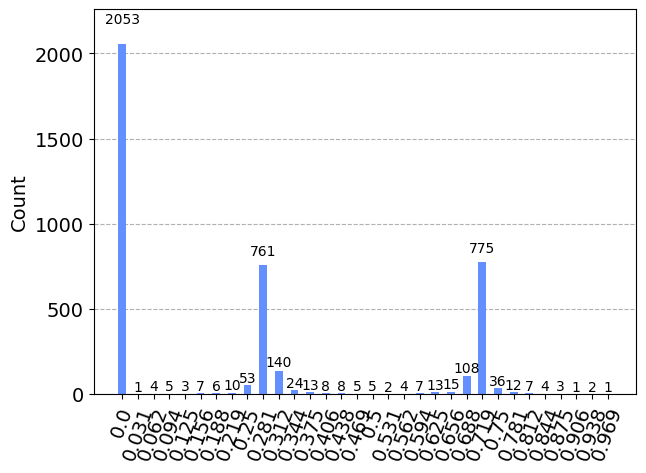

In [32]:
######### (BEGIN) Your answer ##################

tcircuit = transpile(main_circuit, simulator)
result = simulator.run(tcircuit, shots=4096).result()
counts = result.get_counts(tcircuit)
plot_histogram(counts, title='counts')
plot_histogram({bin_to_float(k):v for k,v in counts.items()})

######### ( END ) Your answer ##################

#### Question 7

<span style="color:blue">
    Interpret your results: What do you see and why?
</span>


Using the quantum phase estimation, we can estimate $\theta$, but we know that $cos(\theta) = \sqrt{\frac{N-M}{N}}$ and $sin(\theta) = \sqrt{\frac{M}{N}}$. Using the $\theta$ given by the measurement and the knowledge of $N$, we can compute the number of solutions $M $.

As this graph shows $\phi = \pi\theta$, we can test the result by computing $sin(0.71*pi)^2*8 = 4.99476\ldots$, a good estimation of the expected number of solutions